# TODO

- [WORKING] decide on plots
- [WORKING] add plotting and yield code to the `gcam_demeter_clinic` repo as a package and install:  https://github.com/JGCRI/gcam_demeter_clinic cloned here:  /home/msdadmin/repos/gcam_demeter_clinic
- Check performance:  runtime, memory
- Finalize notebook 
- Deploy notebook where anyone who logs on can access it
- Add disclaimer
- Obfuscate paths
- Add citations and where to get the code/data






# Schedule

-[5] **Greetings**

-[20] **Introductions**:  who are we, and what is this clinic about, and what will you do, and what you should take away from this, mention MSD and GCIMS

-[5-10] **Setup**: login, mention MSD-LIVE

-[30] **GCAM, gcamwrapper**:  What is GCAM, what is GCAM wrapper, ...

-[20] **Demeter**: What is Demeter, why it was created, etc.

-[40] **Demo**: Pralit talks about the context while GCAM is running...may want to discuss what is going on in GCAM


##             ---------- DELETE ABOVE HERE ------------

<img src="../img/banner.png" alt="Powered by MSD-LIVE" width = 600/>


# CSDMS 2021 Annual Meeting

### CLINIC:  Thursday, May 20 11:00am - 1pm MST

## GCAM and Demeter:  A global, integrated human-Earth systems perspective to modeling land projections

### Pralit Patel, pralit.patel<span></span>@pnnl.gov and Chris Vernon, chris.vernon<span></span>@pnnl.gov

Researchers and decision makers are increasingly interested in understanding the many ways in which human and Earth systems interact with one another, at scales from local (e.g., a city) to regional to global. For example, how might changes in population, income, or technology development alter crop production, energy demand, or water withdrawals? How do changes in one region's demand for energy affect energy, water, and land in other regions? This session will focus on two models – GCAM and Demeter – that provide capabilities to address these types of questions.


GCAM is an open-source, global, market equilibrium model that represents the linkages between energy, water, land, climate, and economic systems. A strength of GCAM is that it can be used to quickly explore, and quantify the uncertainty in, a large number of alternate future scenarios while accounting for multi-sector, human-Earth system dynamics. One of GCAM’s many outputs is projected land cover/use by subregion. Subregional projections provide context and can be used to understand regional land dynamics; however, Earth System Models (ESMs) generally require gridded representations of land at finer scales. Demeter, a land use and land cover disaggregation model, was created to provide this service. Demeter directly ingests land projections from GCAM and creates gridded products that match the desired resolution and land class requirements of the user.

This clinic will introduce both GCAM and Demeter at a high-level. We will also provide a hands-on walk through for a reference case so attendees can become familiar with configuring and running these two models. Our goal will be for attendees to leave the clinic with an understanding of 1) the value of capturing a global perspective when informing subregional and local analysis, 2) possibilities to conduct scenario exploration experiments that capture multi-sector/scale dynamics, 3) and a hands-on experience with GCAM and Demeter.

# Value of this demonstration

Demonstrate how to integrate GCAM - using its new Python wrapper - into existing workflows that research energy, water, land, climate, and socioeconomic dynamics to provide a global, human-Earth perspective.

# Import packages

In [42]:
import time
import pkg_resources

import pandas as pd
import geopandas as gpd

import demeter
from demeter import Model
import demo_utils
import gcamwrapper as gw
import im3vis


# Using GCAM via `gcamwrapper`

#### Load GCAM specific files

In [ ]:
# path to the exe directory where gcam-core is installed
core_exe_path = '/home/msdadmin/csdms_demo/gcam-core/exe'

# path to the xml configuration file you want to use
config_xml_file = 'configuration_reduced.xml'


#### Instantiate GCAM

In [ ]:
g = gw.Gcam(config_xml_file, core_exe_path)

#### Run the model through its calibration years through the base year of 2015

In [ ]:
t0 = time.time()

final_cal_period = g.convert_year_to_period(2015)
g.run_to_period(final_cal_period)

print(f"Completed in: {time.time() - t0} seconds.")


#### Query land allocation data from the current GCAM run to produce projected land allocation by land region

In [ ]:
# load query from query library
query_string = gw.get_query('land', 'land_allocation')

# query specific information
query_params = {'region': ['*'], 'leaf': ['*'], 'year': ['<=', g.get_current_year()]}

# create an output data frame containing land data
land_df = g.get_data(query_string, query_params)

land_df.head(6)


## Explore GCAM land allocation outputs for year 2015

In [29]:
# load into a demeter formatted data frame
gcam_df = demeter.format_gcam_data(df=land_df, start_year=2015, through_year=2015)

gcam_df.head()


,region,glu_name,region_id,metric_id,landclass,2015
0,Africa_Eastern,AfrCstE,2,171.0,Corn_IRR,0.026389
1,Africa_Eastern,AfrCstE,2,171.0,Corn_RFD,8.827320
2,Africa_Eastern,AfrCstE,2,171.0,FiberCrop_IRR,0.021205
3,Africa_Eastern,AfrCstE,2,171.0,FiberCrop_RFD,0.189931
4,Africa_Eastern,AfrCstE,2,171.0,Forest,4.855879


#### GCAM total land allocation by region for all land classes

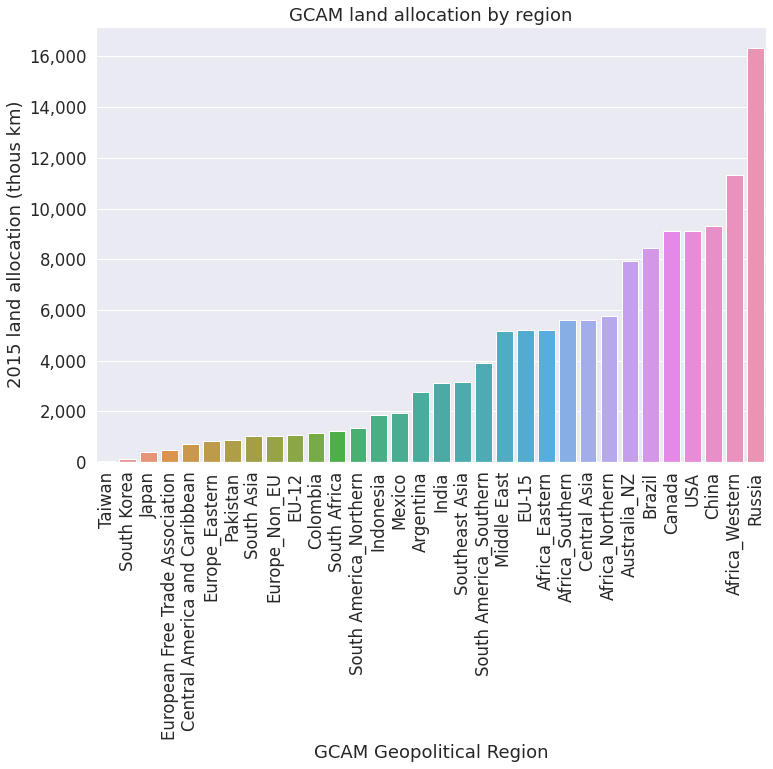

In [31]:
reg_ax = im3vis.gcam_demeter_region(gcam_df, target_year='2015')


#### GCAM total land allocation by region for combined Corn and Wheat

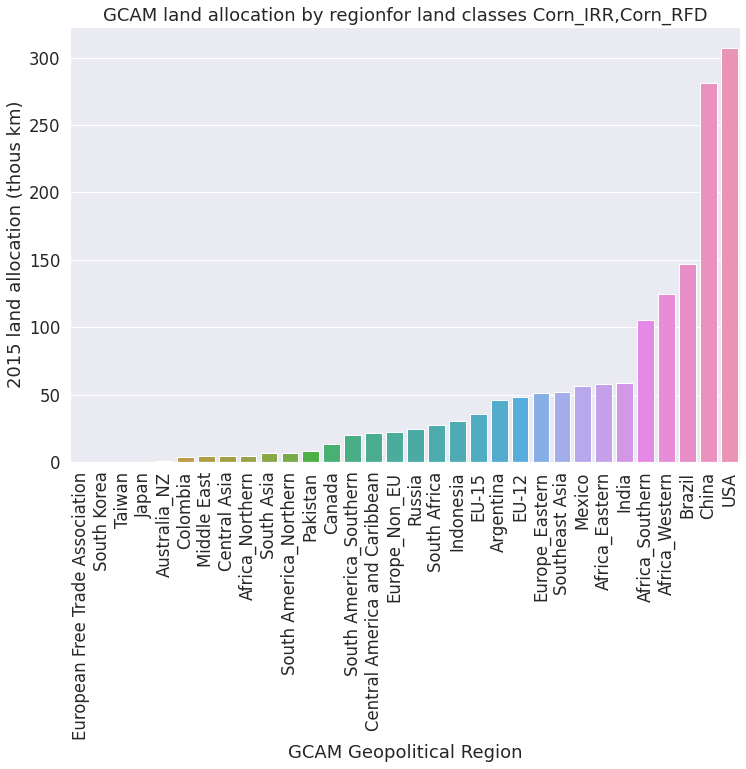

In [34]:
reg_ax = im3vis.gcam_demeter_region(gcam_df, 
                                    target_year='2015', 
                                    landclass_list=['Corn_IRR', 'Corn_RFD'])


#### GCAM `Corn_IRR` allocation for year 2015 for the CONUS

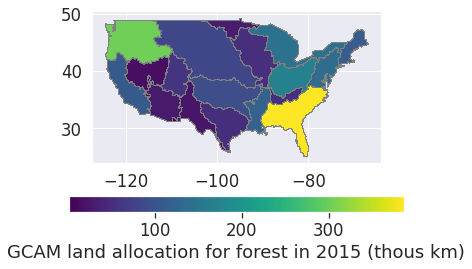

In [37]:
agg_df = im3vis.plot_gcam_conus_basin(gcam_df, 
                                      target_year='2015', 
                                      landclass='forest')


## Run Demeter

#### Instantiate Demeter

In [ ]:
# path to Demeter configuration file on the server
config_file = '/home/msdadmin/csdms_demo/demeter_data/csdms_clinic_config.ini'

# instantiate demeter model
model = Model(config_file=config_file, 
              gcamwrapper_df=land_df,
              write_outputs=False)


#### Load model data and prepare run

In [ ]:
# initialize model
model.initialize()


#### Process the target time step from the GCAM output DataFrame for land allocation

In [ ]:
t0 = time.time()

# process first year
demeter_2015 = model.process_step()

print(f"Completed in: {time.time() - t0} seconds.")


#### Check out Demeter's outputs

In [ ]:
demeter_2015.head()

In [43]:
# bounary shapefile for the CONUS loaded as a geopandas dataframe
conus_boundary_gdf = gpd.read_file(pkg_resources.resource_filename('im3vis', "data/ne_50m_conus.shp"))


In [44]:
# build a geopandas data frame of demeter's output land allocation data with geometry
demeter_gdf = im3vis.build_geodataframe(model.config.observed_lu_file)


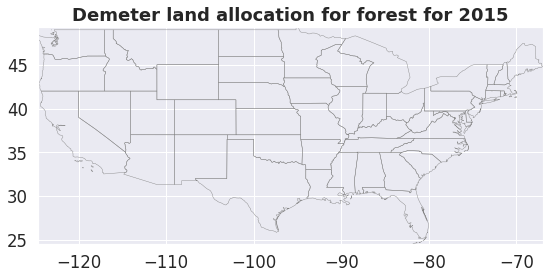

In [45]:
r = im3vis.plot_conus_raster(conus_boundary_gdf, 
                             demeter_gdf, 
                             landclass='forest', 
                             target_year='2015')


#### Clean up the logger

In [ ]:
# cleanup model
model.cleanup()


## Run the next model period (2020) in GCAM _without_ yield impacts

In [ ]:
t0 = time.time()

g.run_to_period()

print(f"Completed in: {time.time() - t0} seconds.")


## Query and visualize model results _without_ accounting for yield impact for comparison purposes

In [25]:
# load query for land allocation
query_string = gw.get_query('land', 'land_allocation')
query_params = {'region': ['*'], 'leaf': ['*'], 'year': ['<=', g.get_current_year()]}

# run the query
land_df = g.get_data(query_string, query_params)

# get Corn producer prices
query_string = gw.get_query('ag', 'prices')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'year': ['=', g.get_current_year()]}

prod_prices = g.get_data(query_string, query_params)

# get domestic Corn prices (accounting for trade)
query_params['sector'] = ["=", 'regional corn']

prod_prices = g.get_data(query_string, query_params)

# finally get the actual yields
query_string = gw.get_query('ag', 'yield')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'tech': ['*'], 
                'year': ['=', g.get_current_year()]}

yields = g.get_data(query_string, query_params)


## Generate yield impacts from ISIMIP PDSST data using downscaled land from Demeter to weight and map them to GCAM land regions

In [ ]:
yield_scaler_df = demo_utils.get_yield_scalers(demeter_2015, g.get_current_year())

yield_scaler_df.head()


In [ ]:
#yields.join(yield_scaler_df.reset_index(), on=["region", "sector", "technology", "year"], how="inner").head()
yields_new = yields.set_index(["region", "sector", "technology", "year"]).join(yield_scaler_df.set_index(["region", "sector", "technology", "year"]), how="inner").reset_index()
yields_new['yield'] *= yields_new['yield_scaler']
yields_new = yields_new.filter(["region", "sector", "technology", "year", "yield"])

yields_new.head()


## Update yields in GCAM for year 2020 and re-run

In [ ]:
# get the same query string
query_string = gw.get_query('ag', 'yield')

# however the syntax for the query params are slightly different for set data as we
# need to explicitly tell it which match with the '+' argument and of course we do
# not give the values to compare against as those are coming from the DataFrame
query_params = {'region': ['+', '='], 
                'sector': ['+', '='], 
                'tech': ['+', '='], 
                'year': ['+', '=']}

g.set_data(yields_new, query_string, query_params)

# re-run 2020
g.run_to_period(g.get_current_period())


## Get the results _with_ impacts for comparison

In [ ]:
# load query for land allocation
query_string = gw.get_query('land', 'land_allocation')
query_params = {'region': ['*'], 
                'leaf': ['*'], 
                'year': ['<=', g.get_current_year()]}

# run the query
land_df_new = g.get_data(query_string, query_params)

# get Corn producer prices
query_string = gw.get_query('ag', 'prices')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'year': ['=', g.get_current_year()]}

prod_prices_new = g.get_data(query_string, query_params)

# get domestic Corn prices (accounting for trade)
query_params['sector'] = ["=", 'regional corn']

prod_prices_new = g.get_data(query_string, query_params)

# finally get the actual yields
query_string = gw.get_query('ag', 'yield')
query_params = {'region': ['*'], 
                'sector': ['=', 'Corn'], 
                'tech': ['*'], 
                'year': ['=', g.get_current_year()]}

yields_new = g.get_data(query_string, query_params)


## Visualizations comparing 2020 with and without crop yield updates

In [ ]:
# either load original run without updates or do two sims

In [ ]:
yields_new.head()

In [ ]:
prod_prices.head()

In [ ]:
prod_prices_new.head()